## Eye for Blind

An CNN-RNN based Attention model has been built on flickr8k dataset to predict captions for random images. The Model selects captions using Greedy Search and resulting captions are evaluated using BLUE score.

### Install Libraries

Install necessary libraries that does not come along with Colab.

In [1]:
# Text to speech library.
!pip install -qU gTTS

### Import Libraries

Import python libraries.

In [1]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pathlib
import pickle
import glob
from tqdm import tqdm
from skimage import io
from collections import Counter
from PIL import Image
from IPython import display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model,activations
from keras.utils import plot_model
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from gtts import gTTS

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:14<00:00, 74.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [7]:
!mv {path} flickr8k

mv: cannot stat '/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1': No such file or directory


### Download flickr dataset

1. Download Flickr dataset
2. Load images and captions


In [3]:
data = 'flickr8k/'
images= os.path.join(data, 'Images/')

raw_images = glob.glob(images + '*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(raw_images)))
raw_images[:2]

The total images present in the dataset: 8091


['flickr8k/Images/269361490_a22ae818bf.jpg',
 'flickr8k/Images/2465218087_fca77998c6.jpg']

In [4]:
df_caption = pd.read_csv(os.path.join(data, 'captions.txt'))
df_caption.head()
len(df_caption)

40455

#### Show images and captions

In [5]:
def show_image_caption(index, ax):
    image_name, caption = df_caption.iloc[index]["image"], df_caption.iloc[index]["caption"]
    ax.imshow(io.imread(pathlib.Path(images,image_name)), cmap=None)
    ax.axis('off')
    ax.set_title(caption)

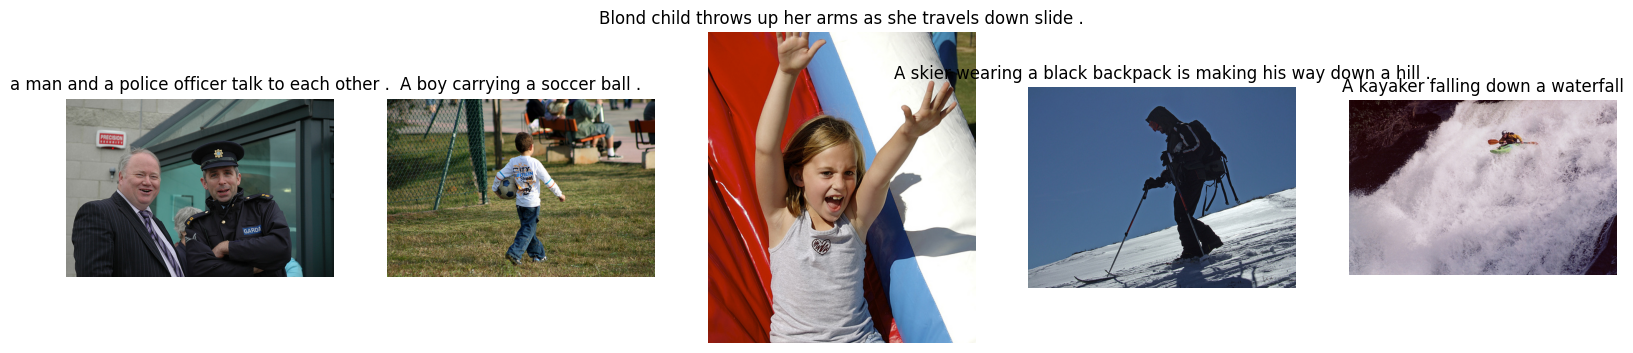

In [6]:

figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for i in range(5) :
    random_index = np.random.randint(0,len(raw_images))
    show_image_caption(random_index, axes[i])

In [7]:
text_file = 'captions.txt'
def load_captions(filename):
    text = pd.read_csv(data + filename)
    return text

doc = load_captions(text_file)
print(f"{doc[:100] = }")

doc[:100] =                         image  \
0   1000268201_693b08cb0e.jpg   
1   1000268201_693b08cb0e.jpg   
2   1000268201_693b08cb0e.jpg   
3   1000268201_693b08cb0e.jpg   
4   1000268201_693b08cb0e.jpg   
..                        ...   
95   102351840_323e3de834.jpg   
96   102351840_323e3de834.jpg   
97   102351840_323e3de834.jpg   
98   102351840_323e3de834.jpg   
99   102351840_323e3de834.jpg   

                                              caption  
0   A child in a pink dress is climbing up a set o...  
1               A girl going into a wooden building .  
2    A little girl climbing into a wooden playhouse .  
3   A little girl climbing the stairs to her playh...  
4   A little girl in a pink dress going into a woo...  
..                                                ...  
95                 A man drilling a hole in the ice .  
96  A man is drilling through the frozen ice of a ...  
97  A person in the snow drilling a hole in the ice .  
98               A person stand

In [8]:
all_img_id = df_caption['image']
all_img_vector = [data + 'Images/' + str(img) for img in all_img_id]
annotations = df_caption['caption']

In [9]:
data = {'ID': all_img_id,'Path':all_img_vector,'Captions':annotations}
df = pd.DataFrame(data=data)
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,flickr8k/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,flickr8k/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,flickr8k/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,flickr8k/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [10]:
#Create a list which contains all the captions
annotations= ['<start> '+ text +' <end>' for text in df.Captions]
#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path= list(df.Path)

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))
print (annotations[:2])

Total captions present in the dataset: 40455
Total images present in the dataset: 40455
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>']


### Create the vocabulary & the counter for the captions

In [11]:
concat_str = ' '.join([str(text).strip('\n') for text in annotations])
vocabulary = concat_str.split(' ')
print(vocabulary[:50])
print("Vocabulary length: "+ str(len(set(vocabulary))))
val_count=Counter(vocabulary)
print(val_count.most_common(50))

['<start>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<end>', '<start>', 'A', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<end>', '<start>', 'A', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<end>', '<start>', 'A', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her']
Vocabulary length: 9632
[('<start>', 40455), ('<end>', 40455), ('a', 40319), ('.', 36577), ('A', 22667), ('in', 18962), ('the', 15328), ('on', 10730), ('is', 9345), ('and', 8850), ('dog', 7984), ('with', 7760), ('man', 6829), ('of', 6712), ('Two', 4365), ('white', 3876), ('black', 3696), ('are', 3503), ('boy', 3442), (',', 3232), ('woman', 3228), ('girl', 3218), ('to', 3173), ('The', 3089), ('wearing', 3061), ('at', 2904), ('water', 2778), ('red', 2660), ('brown', 2475), ('people', 2446), ('young', 2432), ('his', 2357), ('blue', 2259), ('dogs', 2083), ('running', 2072), ('through', 2032), ('

### Top 30 captions

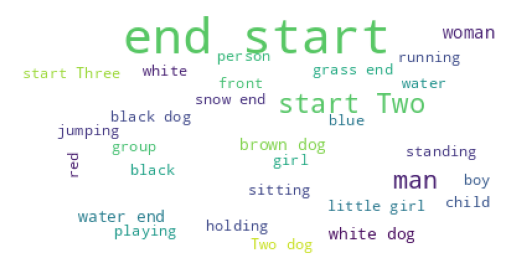

In [12]:
wordcloud = WordCloud(
                          background_color='white',
                          max_words=30,
                          max_font_size=40,
                          random_state=42
                         ).generate(str(annotations))

plt.imshow(wordcloud)
plt.axis('off')
plt.show();

### Top 30 words in captions

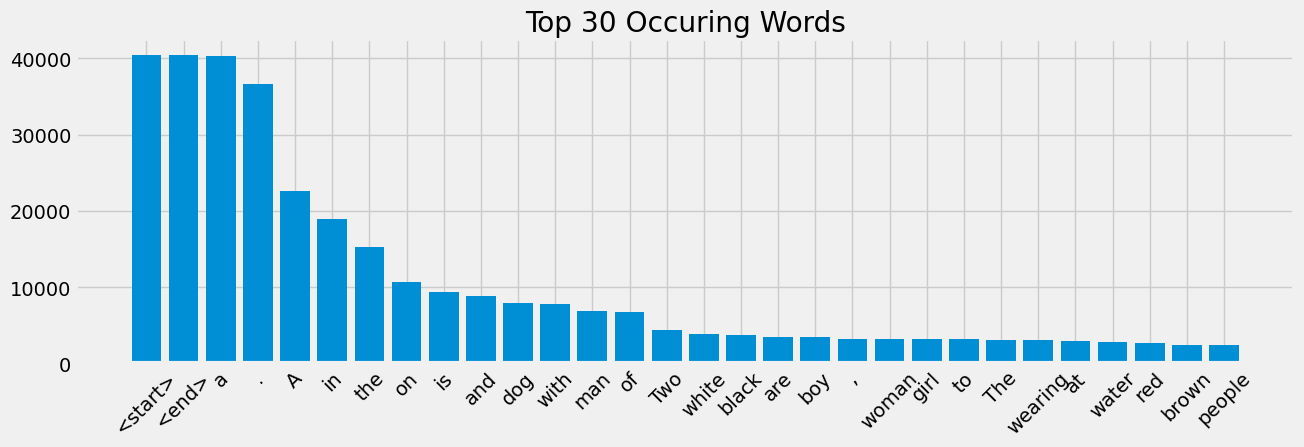

In [13]:
def plot_top_words(word_counter):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(14,4))
    plt.xticks(rotation=45)
    plt.bar(*zip(*word_counter))
    plt.title("Top 30 Occuring Words")
    plt.show()

plot_top_words(val_count.most_common(30))

### Tokenize

In [14]:
top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt +1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False,
                      oov_token = 'UNK')

### Fit and transform textual data into numeric values.

In [15]:
tokenizer.fit_on_texts(annotations)
text_seqs = tokenizer.texts_to_sequences(annotations)
text_seqs[:4]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4]]

In [16]:
word_index = tokenizer.word_index
index_word = tokenizer.index_word

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [17]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [18]:
word_count_dict = dict(tokenizer.word_counts.items())
#word_count_dict
len(word_count_dict)
len(tokenizer.index_word)

8497

In [19]:
## Save Tokenizer
with open('./tokenizer.pkl',"wb") as f:
    pickle.dump(tokenizer,f)

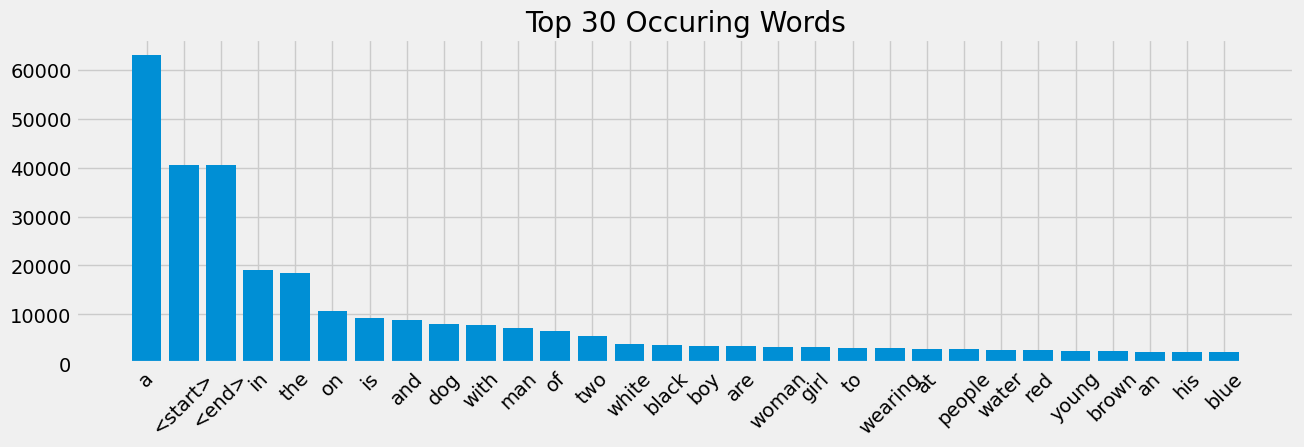

In [20]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)  #kv[1]: word frequency, reverse = True : desc order
plot_top_words(sort_word_by_count[:30])

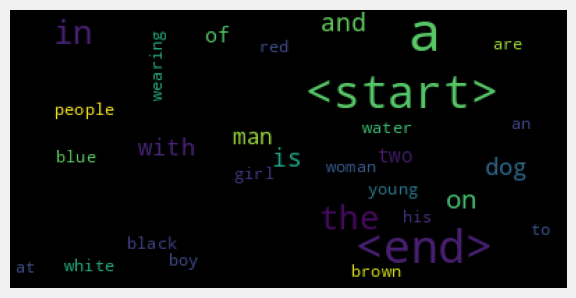

In [21]:
wordcloud = WordCloud(background_color='black',max_words=30,
                          max_font_size=40,
                          random_state=42).generate_from_frequencies(word_count_dict)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [22]:
# Pad each vector to the max_length of the captions  store it to a vairable
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(text_seqs, padding= 'post',
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


In [23]:
IMAGE_SHAPE = (299,299)

### Resize images

In [24]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = preprocess_input(img)
    return img, image_path

print(f'Size of image before preprocessing: {io.imread(all_img_vector[0]).shape}')
print(f'Size of image after preprocessing: {preprocess_image(all_img_vector[0])[0].shape}')

Size of image before preprocessing: (500, 375, 3)
Size of image after preprocessing: (299, 299, 3)


In [25]:
len(sorted(set(all_img_vector)))

8091

In [26]:
# write your code here to create the dataset consisting of image paths
# write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
unique_img_paths = sorted(set(all_img_vector))
img_data = tf.data.Dataset.from_tensor_slices(unique_img_paths[:100])
print(img_data)
img_data = img_data.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)

In [27]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input  #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output  #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [28]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
fv_dict = {}
for img,path in tqdm(img_data):
    fv_out = image_features_extract_model(img)
    fv_flattened = tf.reshape(fv_out,(fv_out.shape[0],-1,fv_out.shape[3]))
    for fv_img,path in zip(fv_flattened,path):
        path = path.numpy().decode("utf-8") #This decoding is done because the values are not in ASCII
        fv_dict[path] = fv_img.numpy()  #This will convert the tensor instance to numpy

100%|██████████| 2/2 [00:40<00:00, 20.44s/it]


In [29]:
print(fv_out.shape) # Last batch has only 27 images (126*64 + 27 = 8091)
print(fv_out[0].shape)
print(fv_flattened.shape)
print(fv_flattened[0].shape)

(36, 8, 8, 2048)
(8, 8, 2048)
(36, 64, 2048)
(64, 2048)


In [30]:
len(fv_dict)

100

In [31]:
#view top five items of features dict
import more_itertools
top_5 = more_itertools.take(5, fv_dict.items())
top_5

[('flickr8k/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.16987054],
         [0.        , 0.        , 1.0105925 , ..., 0.        , 0.        ,
          0.06111754],
         ...,
         [0.        , 0.        , 2.0380423 , ..., 1.2029724 , 0.        ,
          1.9924127 ],
         [0.        , 0.        , 0.9046893 , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2527275 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('flickr8k/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.66368246, 0.46285743, ..., 0.        , 0.        ,
          3.3322656 ],
         [0.        , 1.2268169 , 0.        , ..., 0.        , 0.25390136,
          3.3295348 ],
         [1.288193  , 1.5195413 , 0.        , ..., 0.46777642, 0.36474523,
          3.817

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature.

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [51]:
# write your code here
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector[:1000], cap_vector[:1000], test_size = 0.2, random_state = 42)

In [52]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 800
Testing data for images: 200
Training data for Captions: 800
Testing data for Captions: 200


In [53]:
# Create a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img_path, cap):
    img_tensor = fv_dict[img_path.decode('utf-8')]
    return img_tensor, cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [54]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
# tf.numpy_function() : Wraps a python function and uses it as a TensorFlow op.

BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img_path, cap):

    dataset = tf.data.Dataset.from_tensor_slices((img_path, cap))
    dataset = dataset.map(lambda ele1, ele2 : tf.numpy_function(map_func, [ele1, ele2], [tf.float32, tf.int32]),num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = (dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE , drop_remainder = False).prefetch(tf.data.experimental.AUTOTUNE))
    return dataset



In [38]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [55]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [56]:
embedding_dim = 256
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train)  // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

In [57]:
train_num_steps

12

In [58]:
test_num_steps

3

Encoder

In [59]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = layers.Dense(embed_dim) #build your Dense layer with relu activation

    def call(self, features):
        features =  self.dense(features)# extract the features from the image shape: (batch, 8*8, embed_dim)
        features = activations.relu(features)
        return features

    def model(self):
        features = keras.Input(shape = (64,2048), batch_size = 64)

        return Model(inputs = features, outputs = self.call(features))

In [60]:
encoder=Encoder(embedding_dim)

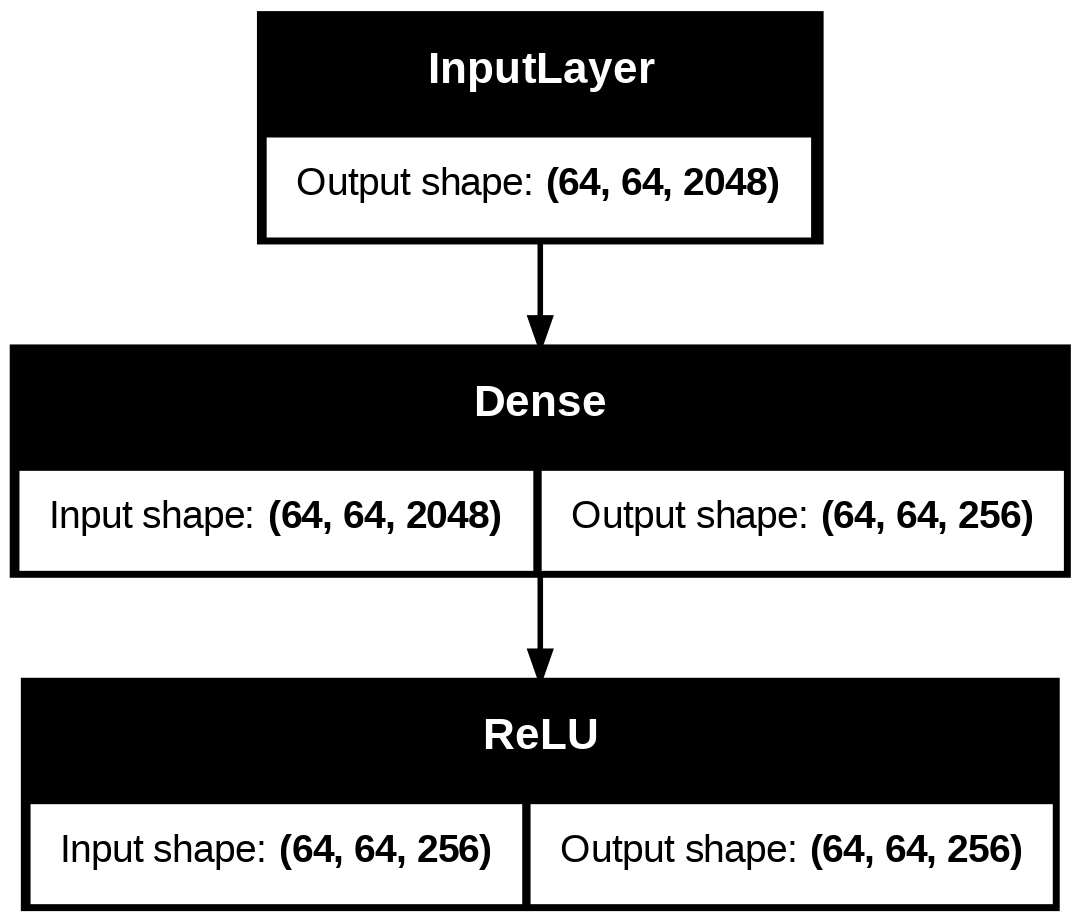

In [61]:
plot_model(encoder.model(),to_file = 'encoder.png', show_shapes = True)

In [62]:
encoder.model().summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (64, 64, 2048)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (64, 64, 256)               │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (64, 64, 256)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 524,544 (2.00 MB)

 Trainable params: 524,544 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

## Attention Model

In [94]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden,1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score,axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features#shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector =  tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)


        return context_vector, attention_weights

Decoder

In [98]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed =  self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [99]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [100]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [103]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')  #Since decoder does not have a softmax therefore, logits = True

In [104]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [105]:
!ls working

ls: cannot access 'working': No such file or directory


In [107]:
if not os.path.exists("working/checkpoints/"):
    os.mkdir("working")
    os.mkdir("working/checkpoints/")

In [108]:
checkpoint_path = "/kaggle/working/checkpoints/"
#checkpoint_path = os.path.join("checkpoints","train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)



In [109]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

[link text](https://)* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [110]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)  #Teacher enforcing
        avg_loss = (loss/target.shape[1])  #Avg loss over a caption
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [113]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1,target.shape[1]):
        predictions,hidden,_ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        predicted_id = tf.argmax(predictions,1)  # No Teacher enforcing
        dec_input = tf.expand_dims(predicted_id, 1)

    avg_loss = (loss/target.shape[1])  #Avg loss over a batch

    return loss, avg_loss

In [111]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps

    return avg_test_loss

In [114]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss

        ckpt_manager.save()


  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.356, & test loss is 0.750
Time taken for 1 epoch 25.584994316101074 sec

Test loss has been reduced from 100.000 to 0.750


  7%|▋         | 1/15 [00:25<06:01, 25.80s/it]

For epoch: 2, the train loss is 0.290, & test loss is 0.665
Time taken for 1 epoch 14.06569242477417 sec

Test loss has been reduced from 0.750 to 0.665


 20%|██        | 3/15 [00:54<03:20, 16.70s/it]

For epoch: 3, the train loss is 0.254, & test loss is 0.681
Time taken for 1 epoch 13.89790654182434 sec



 27%|██▋       | 4/15 [01:07<02:48, 15.35s/it]

For epoch: 4, the train loss is 0.248, & test loss is 0.688
Time taken for 1 epoch 13.284697771072388 sec



 33%|███▎      | 5/15 [01:20<02:24, 14.50s/it]

For epoch: 5, the train loss is 0.245, & test loss is 0.685
Time taken for 1 epoch 12.976951122283936 sec



 40%|████      | 6/15 [01:32<02:03, 13.74s/it]

For epoch: 6, the train loss is 0.231, & test loss is 0.693
Time taken for 1 epoch 12.256469964981079 sec



 47%|████▋     | 7/15 [01:45<01:46, 13.31s/it]

For epoch: 7, the train loss is 0.240, & test loss is 0.702
Time taken for 1 epoch 12.431133031845093 sec



 53%|█████▎    | 8/15 [01:58<01:33, 13.30s/it]

For epoch: 8, the train loss is 0.224, & test loss is 0.697
Time taken for 1 epoch 13.268072128295898 sec



 60%|██████    | 9/15 [02:11<01:18, 13.17s/it]

For epoch: 9, the train loss is 0.228, & test loss is 0.690
Time taken for 1 epoch 12.86934757232666 sec



 67%|██████▋   | 10/15 [02:24<01:06, 13.22s/it]

For epoch: 10, the train loss is 0.229, & test loss is 0.685
Time taken for 1 epoch 13.35128378868103 sec



 73%|███████▎  | 11/15 [02:37<00:52, 13.14s/it]

For epoch: 11, the train loss is 0.232, & test loss is 0.679
Time taken for 1 epoch 12.941465854644775 sec



 80%|████████  | 12/15 [02:50<00:39, 13.19s/it]

For epoch: 12, the train loss is 0.224, & test loss is 0.676
Time taken for 1 epoch 13.313039302825928 sec



 87%|████████▋ | 13/15 [03:03<00:26, 13.15s/it]

For epoch: 13, the train loss is 0.226, & test loss is 0.671
Time taken for 1 epoch 13.058425188064575 sec



 93%|█████████▎| 14/15 [03:17<00:13, 13.17s/it]

For epoch: 14, the train loss is 0.217, & test loss is 0.665
Time taken for 1 epoch 13.216866493225098 sec

For epoch: 15, the train loss is 0.216, & test loss is 0.661
Time taken for 1 epoch 12.314239025115967 sec

Test loss has been reduced from 0.665 to 0.661


100%|██████████| 15/15 [03:29<00:00, 13.97s/it]


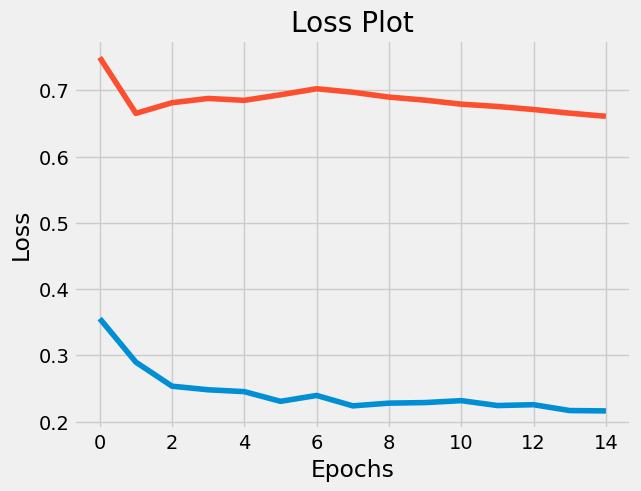

In [115]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [120]:
!ls working/checkpoints/

In [119]:
!cat ./checkpoints/checkpoint

cat: ./checkpoints/checkpoint: No such file or directory


In [121]:
print('shpe of loss_plot', loss_plot)
print('shpe of test_loss_plot', test_loss_plot)

shpe of loss_plot [<tf.Tensor: shape=(), dtype=float32, numpy=0.35557947>, <tf.Tensor: shape=(), dtype=float32, numpy=0.28981224>, <tf.Tensor: shape=(), dtype=float32, numpy=0.25356075>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2481432>, <tf.Tensor: shape=(), dtype=float32, numpy=0.24533284>, <tf.Tensor: shape=(), dtype=float32, numpy=0.23072128>, <tf.Tensor: shape=(), dtype=float32, numpy=0.23958619>, <tf.Tensor: shape=(), dtype=float32, numpy=0.22388774>, <tf.Tensor: shape=(), dtype=float32, numpy=0.22800231>, <tf.Tensor: shape=(), dtype=float32, numpy=0.22883613>, <tf.Tensor: shape=(), dtype=float32, numpy=0.23177898>, <tf.Tensor: shape=(), dtype=float32, numpy=0.22436886>, <tf.Tensor: shape=(), dtype=float32, numpy=0.22563076>, <tf.Tensor: shape=(), dtype=float32, numpy=0.21679555>, <tf.Tensor: shape=(), dtype=float32, numpy=0.21627028>]
shpe of test_loss_plot [<tf.Tensor: shape=(), dtype=float32, numpy=0.7495203>, <tf.Tensor: shape=(), dtype=float32, numpy=0.6651944>, <tf.Tens

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [122]:
attention_features_shape = 64
max_seq_length = cap_vector.shape[1]
def evaluate(image):
    attention_plot = np.zeros((max_seq_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)  # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)  # extract the features by passing the input to encoder
    #print("shape of features", features.shape)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    #print("shape of first dec_input", dec_input.shape)
    result = []

    for i in range(max_seq_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)# get the output from decoder
        #print("shape of predictions", predictions.shape)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = (tf.argmax(predictions,1)).numpy()[0]  #extract the predicted id(index value from tokenizer) which carries the max value
        #print("predicted_id:", predicted_id)
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)


    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

'''
Shape of features: (1,64,256)
Shape of first dec_input: (1,1)
Shape of predictions: (1,5001)
'''



'\nShape of features: (1,64,256)\nShape of first dec_input: (1,1)\nShape of predictions: (1,5001)\n'

In [123]:
attention_features_shape = 64
max_seq_length = cap_vector.shape[1]
def beam_evaluate(image, beam_index = 3):

    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_seq_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_seq_length:
        temp = []
        for i, s in enumerate(result):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


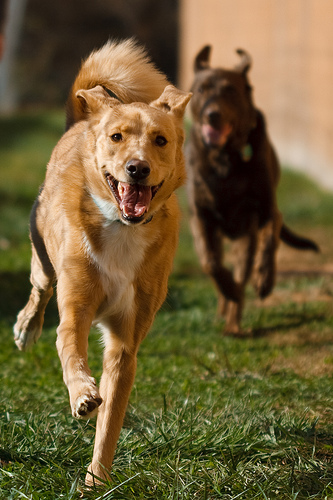

In [125]:
test_image = "flickr8k/Images/3106883334_419f3fb16f.jpg"
captions=beam_evaluate(test_image)
print(captions)
Image.open(test_image)

In [126]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [127]:
from nltk.translate.bleu_score import sentence_bleu

In [128]:
def filt_text(text):
    filt=['<start>','UNK','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [129]:
def test_caption_generation(img_test_batch):
    rid = np.random.randint(0, len(img_test_batch))
    test_image = img_test_batch[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)


    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights= (0.5,0.5,0,0))  #set your weights
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    Image.open(test_image)

    ##Converting text to speech
    tts = gTTS(pred_caption, lang = 'en', slow = False)
    #This can be downloaded and played
    filename = 'working/caption.mp3'
    tts.save(filename)
    display.display(display.Audio(filename, rate = None, autoplay = False)) # To display playback bar as output


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BELU score: 3.422121424610076e-153
Real Caption: a man and woman care for an infant along the side of a body of water
Prediction Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


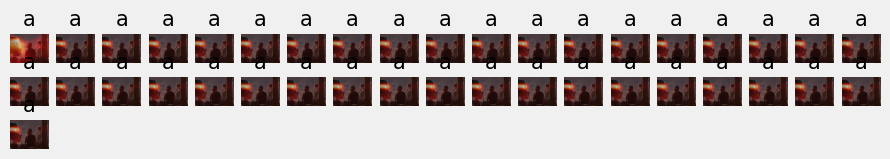

In [130]:
test_caption_generation(path_test)